## Variational Inference: Bayesian Neural Networks

This notebook is largely inspired to the tutorial that can be found in the PyMC website --- https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html

**Current trends in Machine Learning**: Probabilistic Programming, Deep Learning, and "Big Data" are nowadays major trends in machine learning. Within Probabilistic Programming, a major focus of innovation lies in scaling processes through Variational Inference. In the following example, we will demonstrate the application of Variational Inference with PyMC to fit a simple Bayesian Neural Network.

**Probabilistic Programming at scale**: Probabilistic Programming allows flexible creation of custom probabilistic models and is concerned with inference and learning from your data. **What is Bayesian in all this?**  The approach is inherently **Bayesian** so we can specify **priors** to inform and constrain our models and get uncertainty estimation in form of a **posterior** distribution.

Using MCMC sampling algorithms we can draw samples from this posterior to very flexibly estimate these models. PyMC, NumPyro, and Stan are the current state-of-the-art tools for constructing and estimating these models. `One major drawback of sampling, however, is that it’s often slow, especially for high-dimensional models and large datasets`.
That's why, more recently, developers have introduced variational inference algorithms that match the flexibility of MCMC while being significantly quicker. Rather than sampling from the posterior, these algorithms fit a distribution (such as a normal distribution) to the posterior, transforming a sampling problem into an optimization problem.

**Automatic Differentation Variational Inference** is implemented in several probabilistic programming packages including PyMC, NumPyro and Stan.

When addressing traditional machine learning tasks such as classification or non-linear regression, Probabilistic Programming typically takes a back seat in terms of accuracy and scalability compared to more algorithmic approaches like ensemble learning, including methods such as random forests and gradient boosted regression trees.
On the other hand, Probabilistic Programming enables the acquisition of the posterior distribution and facilitates uncertainty quantification. This provides important and somewhat complementary information that can assist in characterizing the decision-making process.

**Deep Learning**: Deep learning models are especially effective as non-linear function approximators and representation learners. They gained widespread recognition a decade ago through remarkable achievements, including outperforming human players in Atari games [arXiv:1312.5602, 2013](https://arxiv.org/abs/1312.5602), defeating world champion Lee Sedol in the game of Go [Nature, 529:484–489, 2016](https://doi.org/10.1038/nature16961), and advancing unsupervised learning tasks [arXiv:1312.6114, 2013](https://arxiv.org/abs/1312.6114). These milestones were followed by a multitude of other methods and applications, leading to the recent surge in generative AI technologies.   

Deep learning has advanced significantly through innovations that made possible training complex models. Key factors include:

1. Speed: GPU utilization has drastically increased processing capabilities.
2. Software: Frameworks like PyTorch and TensorFlow enable the creation and optimization of models for CPUs and GPUs.
3. Learning Algorithms: Techniques like stochastic gradient descent and dropout facilitate training on large datasets and help prevent overfitting.
4. Architectural: Innovations in input and output layers, notably in convolutional neural networks, enhance model performance.
These developments collectively push the boundaries of what deep learning can achieve.

### Bridging Deep Learning and Probabilistic Programming


On one hand, Probabilistic Programming enables us to construct relatively small, focused models in a highly principled and well-understood manner, providing deep insights into our data. On the other hand, deep learning employs numerous heuristics to train vast and complex models that excel in prediction. Recent advances in variational inference have allowed Probabilistic Programming to scale both model complexity and data size. Consequently, we are on the brink of merging these two approaches, potentially leading to groundbreaking innovations in Machine Learning.

### Bayesian Neural Networks in PyMC

In [4]:
#--- data generation

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [6]:
%config InlineBackend.figure_format = 'retina' # used to configure the way matplotlib graphs are displayed in a Jupyter notebook
floatX = pytensor.config.floatX # This line sets the variable floatX to the default floating-point data type used by a library
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [7]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
cancer1 = load_breast_cancer()

cancer = pd.DataFrame(cancer1.data, columns=cancer1.feature_names)
cancer.columns = cancer.columns.str.replace(' ','_')

# Add a column for the response variable: malignant or benign
cancer['Target'] = cancer1.target

In [24]:
X = cancer[['mean_radius','mean_texture']].values

In [25]:
Y = cancer[['Target']].values.reshape(-1)

In [26]:
#X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

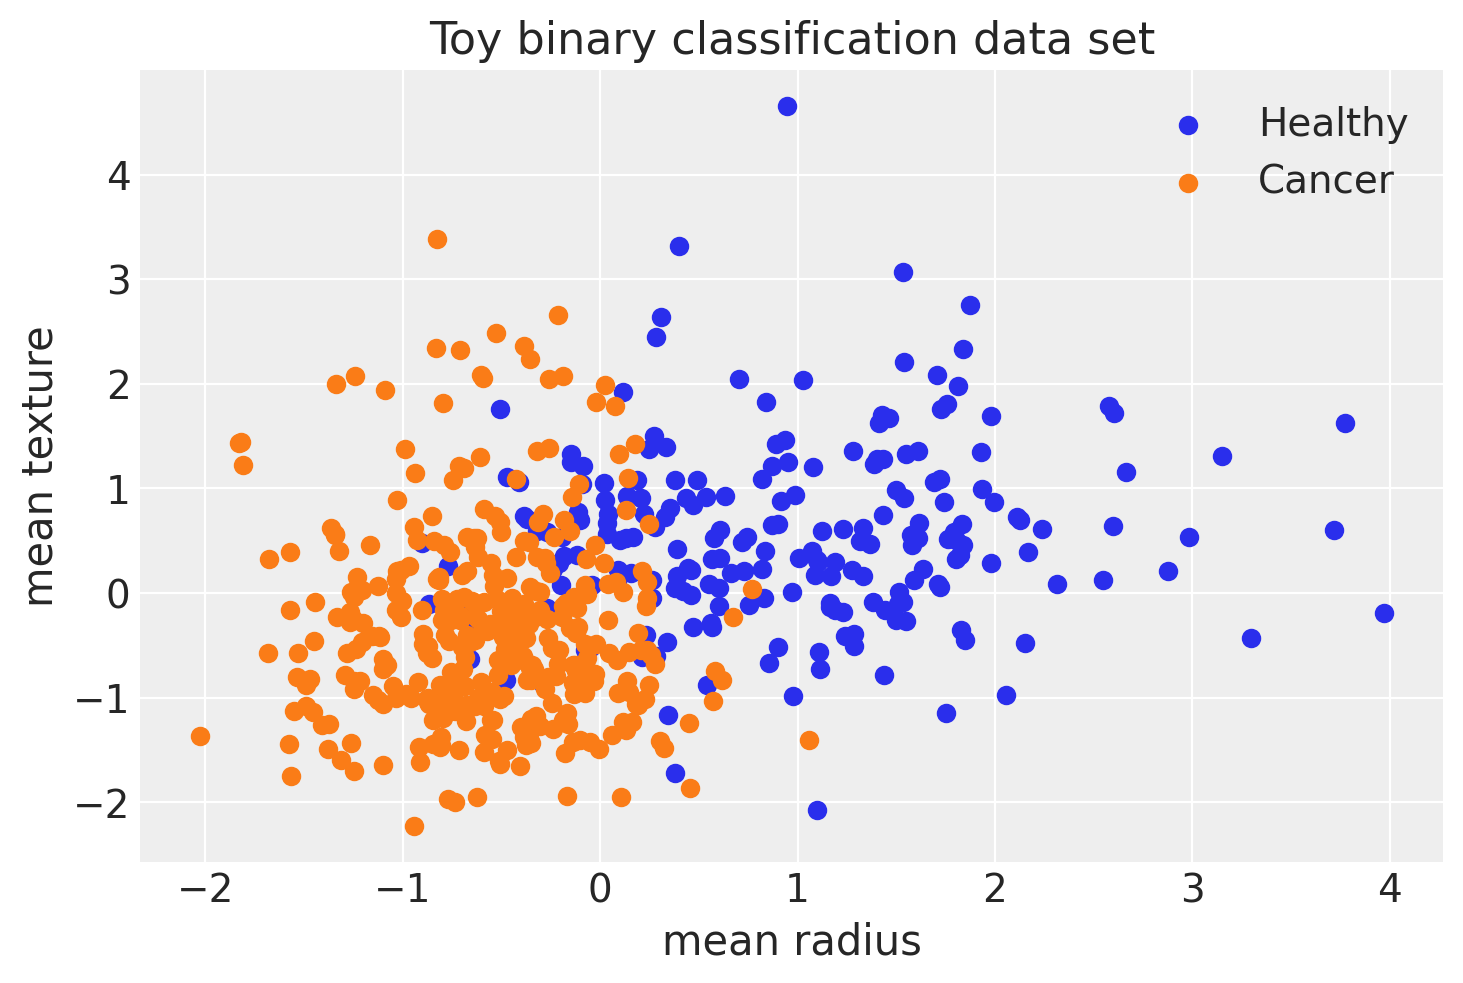

In [27]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="C0", label="Healthy")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="C1", label="Cancer")
sns.despine()
ax.legend()
ax.set(xlabel="mean radius", ylabel="mean texture", title="Toy binary classification data set");

### Model Specification

The basic unit is a perceptron which is nothing more than logistic regression. We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [37]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", Y_train, mutable=True, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  #  total size of the datase, IMPORTANT for minibatches
            dims="obs_id", #  defines the dimension label for the observed data, useful e.g. when using minibatches etc
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

The Normal priors help regularize the weights. Usually we would add a constant bias `b` to the inputs but this is omitted here to keep the code cleaner.



### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like `pymc.NUTS` which works pretty well in this case, but was already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers. Instead, we will use the `pymc.ADVI` variational inference algorithm. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [38]:
%%time

with neural_network:
    approx = pm.fit(n=30_000, method='advi')   #default method is advi
    # Explore usage of callbacks=[pm.callbacks.CheckParametersConvergence()], obj_optimizer=pm.adam(learning_rate=0.001) --- from PyMC3

CPU times: user 32 s, sys: 259 ms, total: 32.2 s
Wall time: 33.9 s


Plotting the objective function (ELBO) we can see that the optimization iteratively improves the fit.



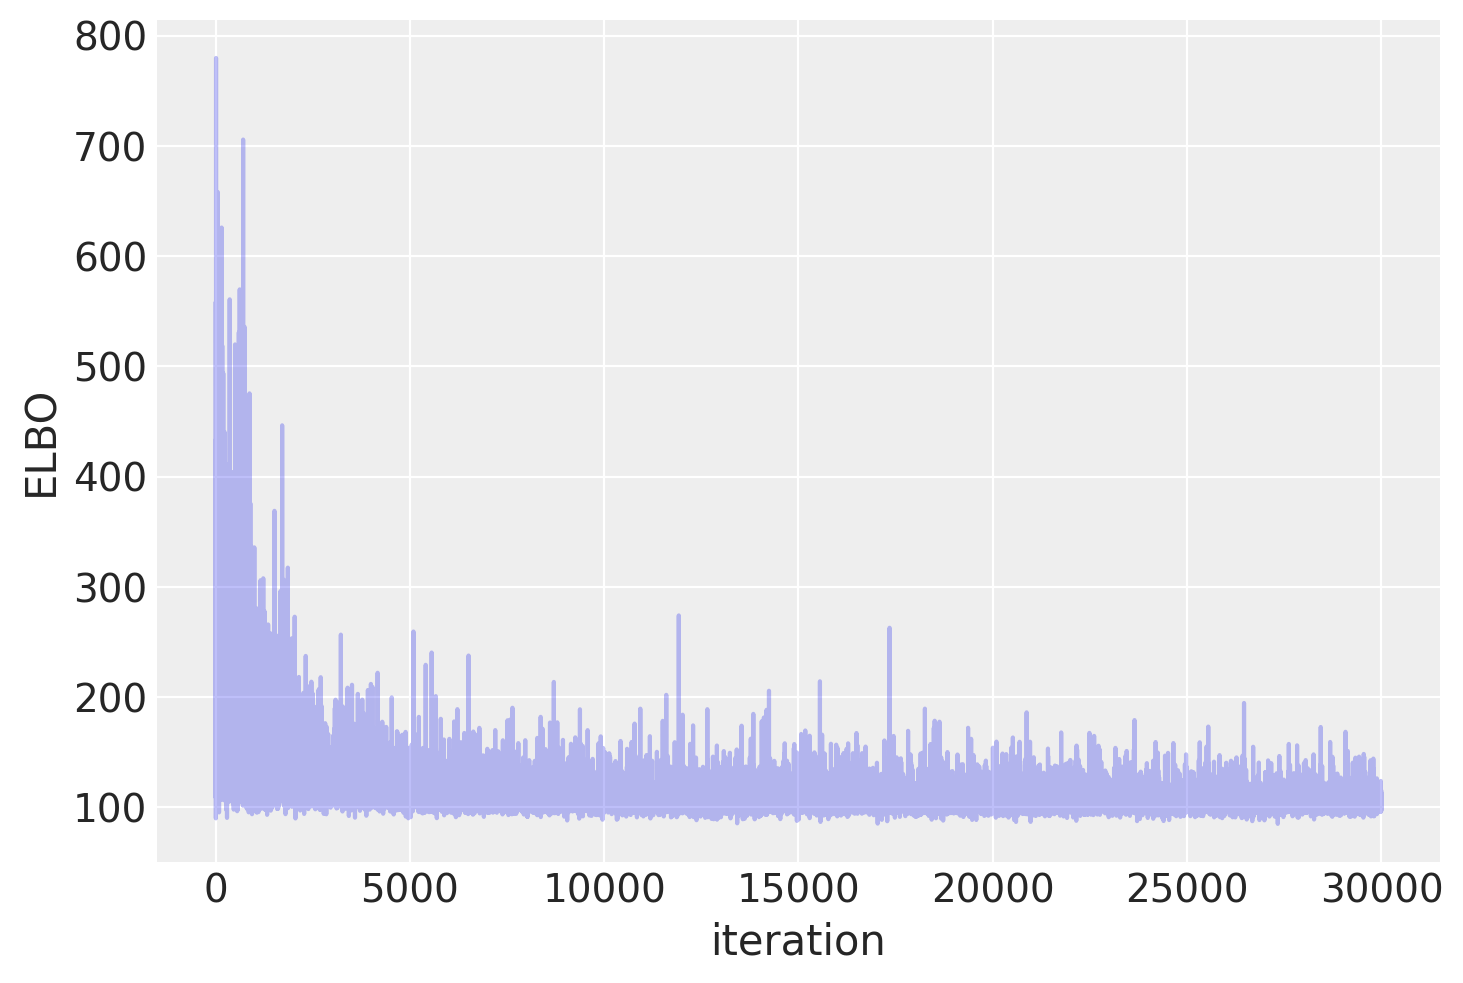

In [30]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [62]:
trace = approx.sample(draws=2500)

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). We can use `sample_posterior_predictive()` to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).

In [63]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc) # to add the posterior predictive samples to trace or not.

We can average the predictions for each observation to estimate the underlying probability of class 1.

In [64]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.5

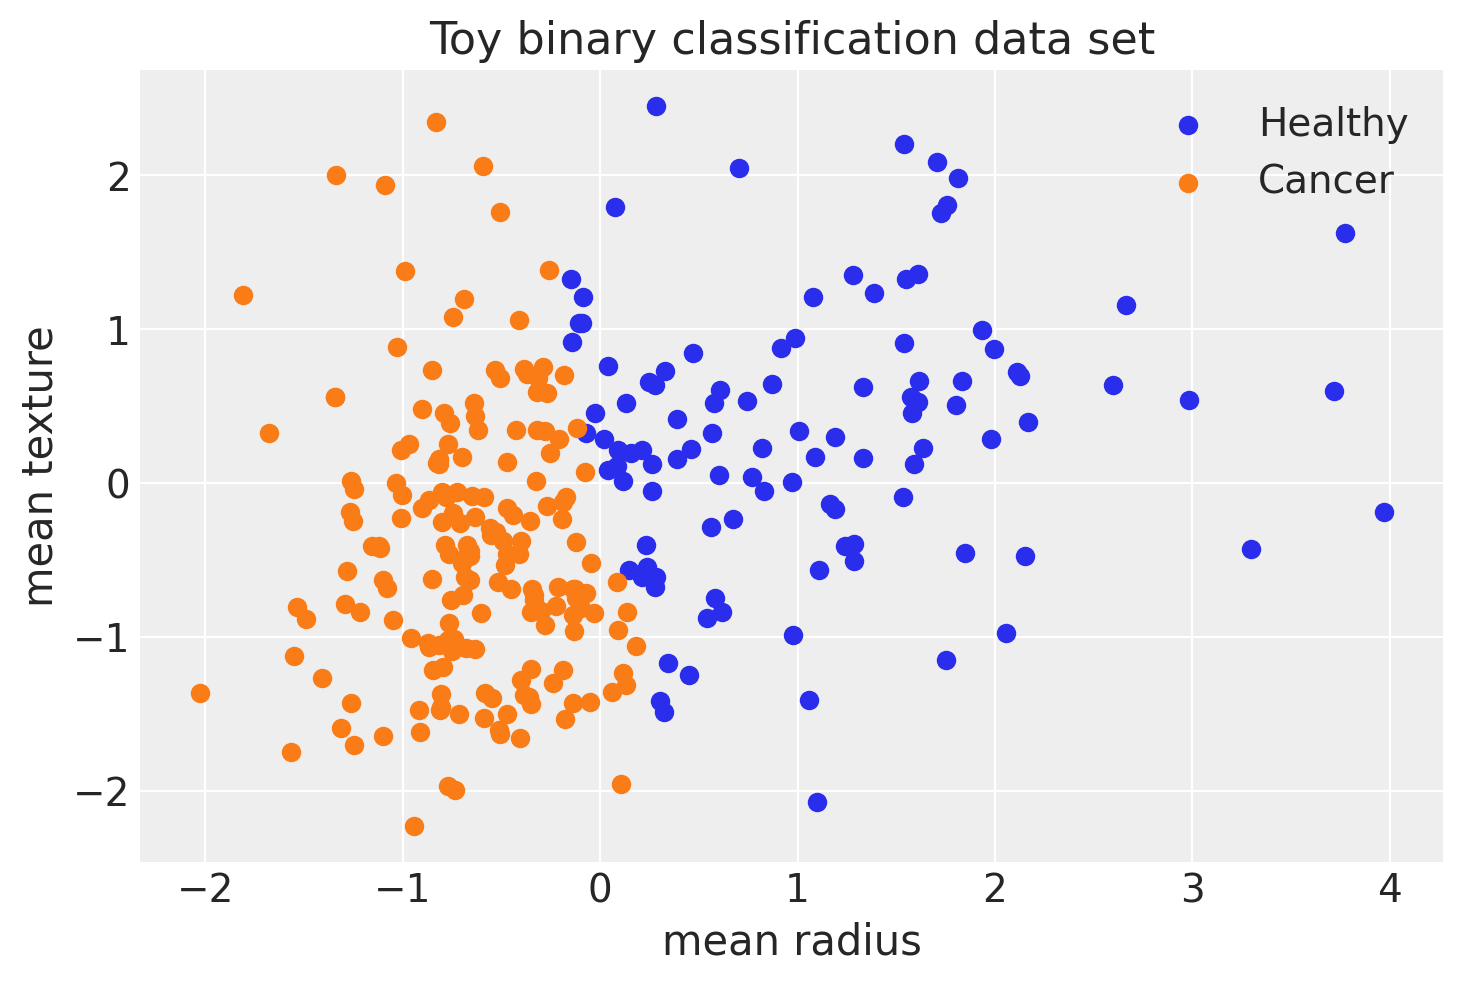

In [65]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0", label="Healthy")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1", label="Cancer")
ax.legend()
sns.despine()
ax.set(xlabel="mean radius", ylabel="mean texture", title="Toy binary classification data set");

In [66]:
print(f"Accuracy = {(Y_test == pred.values).mean() * 100:.2f}%")

Accuracy = 87.37%


### Let's look at what the classifer has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.



In [67]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

In [68]:
print(np.shape(grid_2d))
print(np.shape(dummy_out))

(10000, 2)
(10000,)


In [69]:
with neural_network:
    pm.set_data(new_data={"ann_input": grid_2d, "ann_output": dummy_out})
    ppc = pm.sample_posterior_predictive(trace)

In [70]:
y_pred = ppc.posterior_predictive["out"]

### Probability Surface

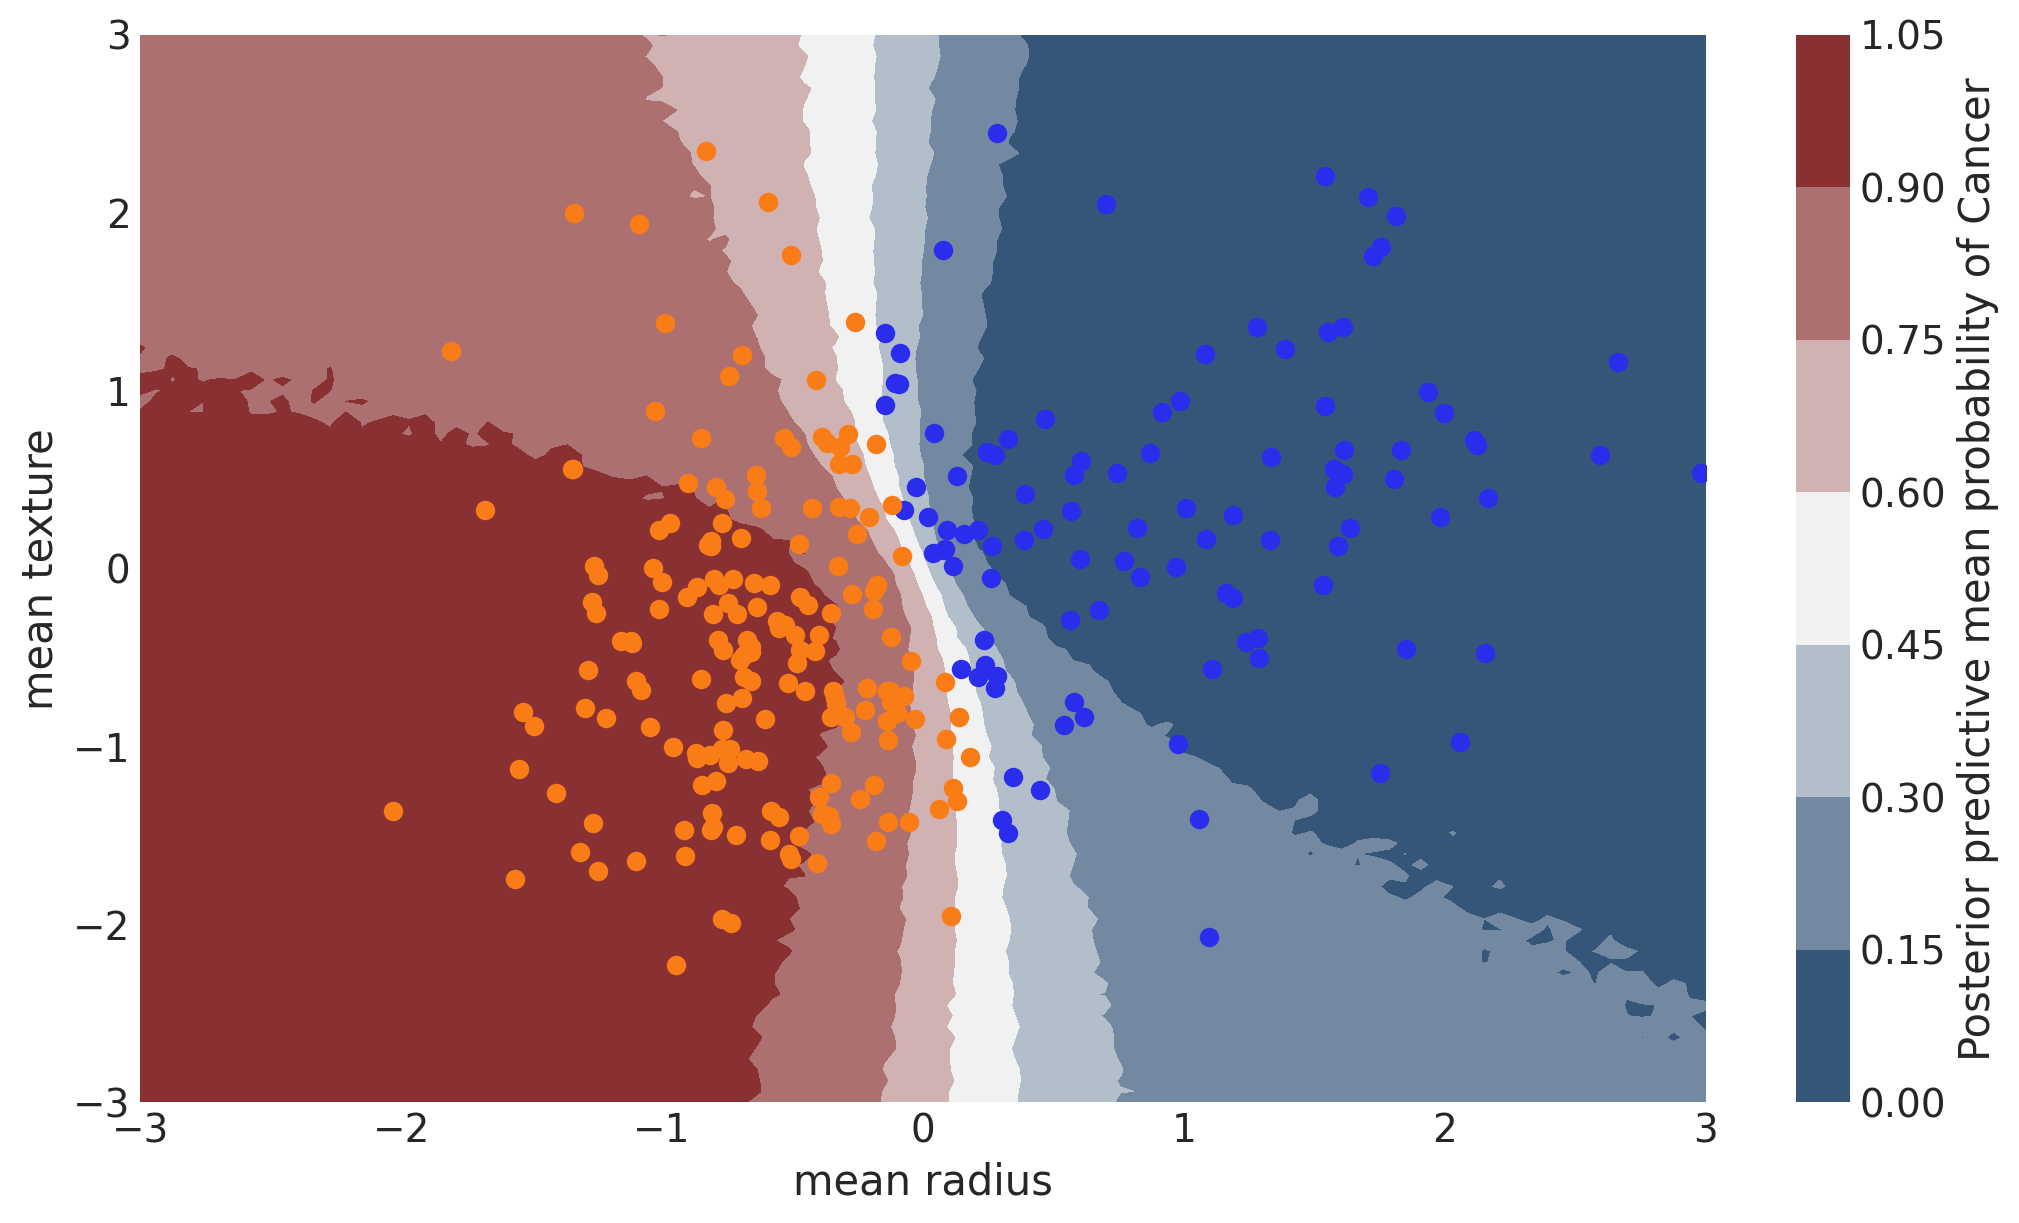

In [71]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(
    grid[0], grid[1], y_pred.mean(("chain", "draw")).values.reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="mean radius", ylabel="mean texture")
cbar.ax.set_ylabel("Posterior predictive mean probability of Cancer");

### Uncertainty in predicted value

Note that we could have done everything above with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

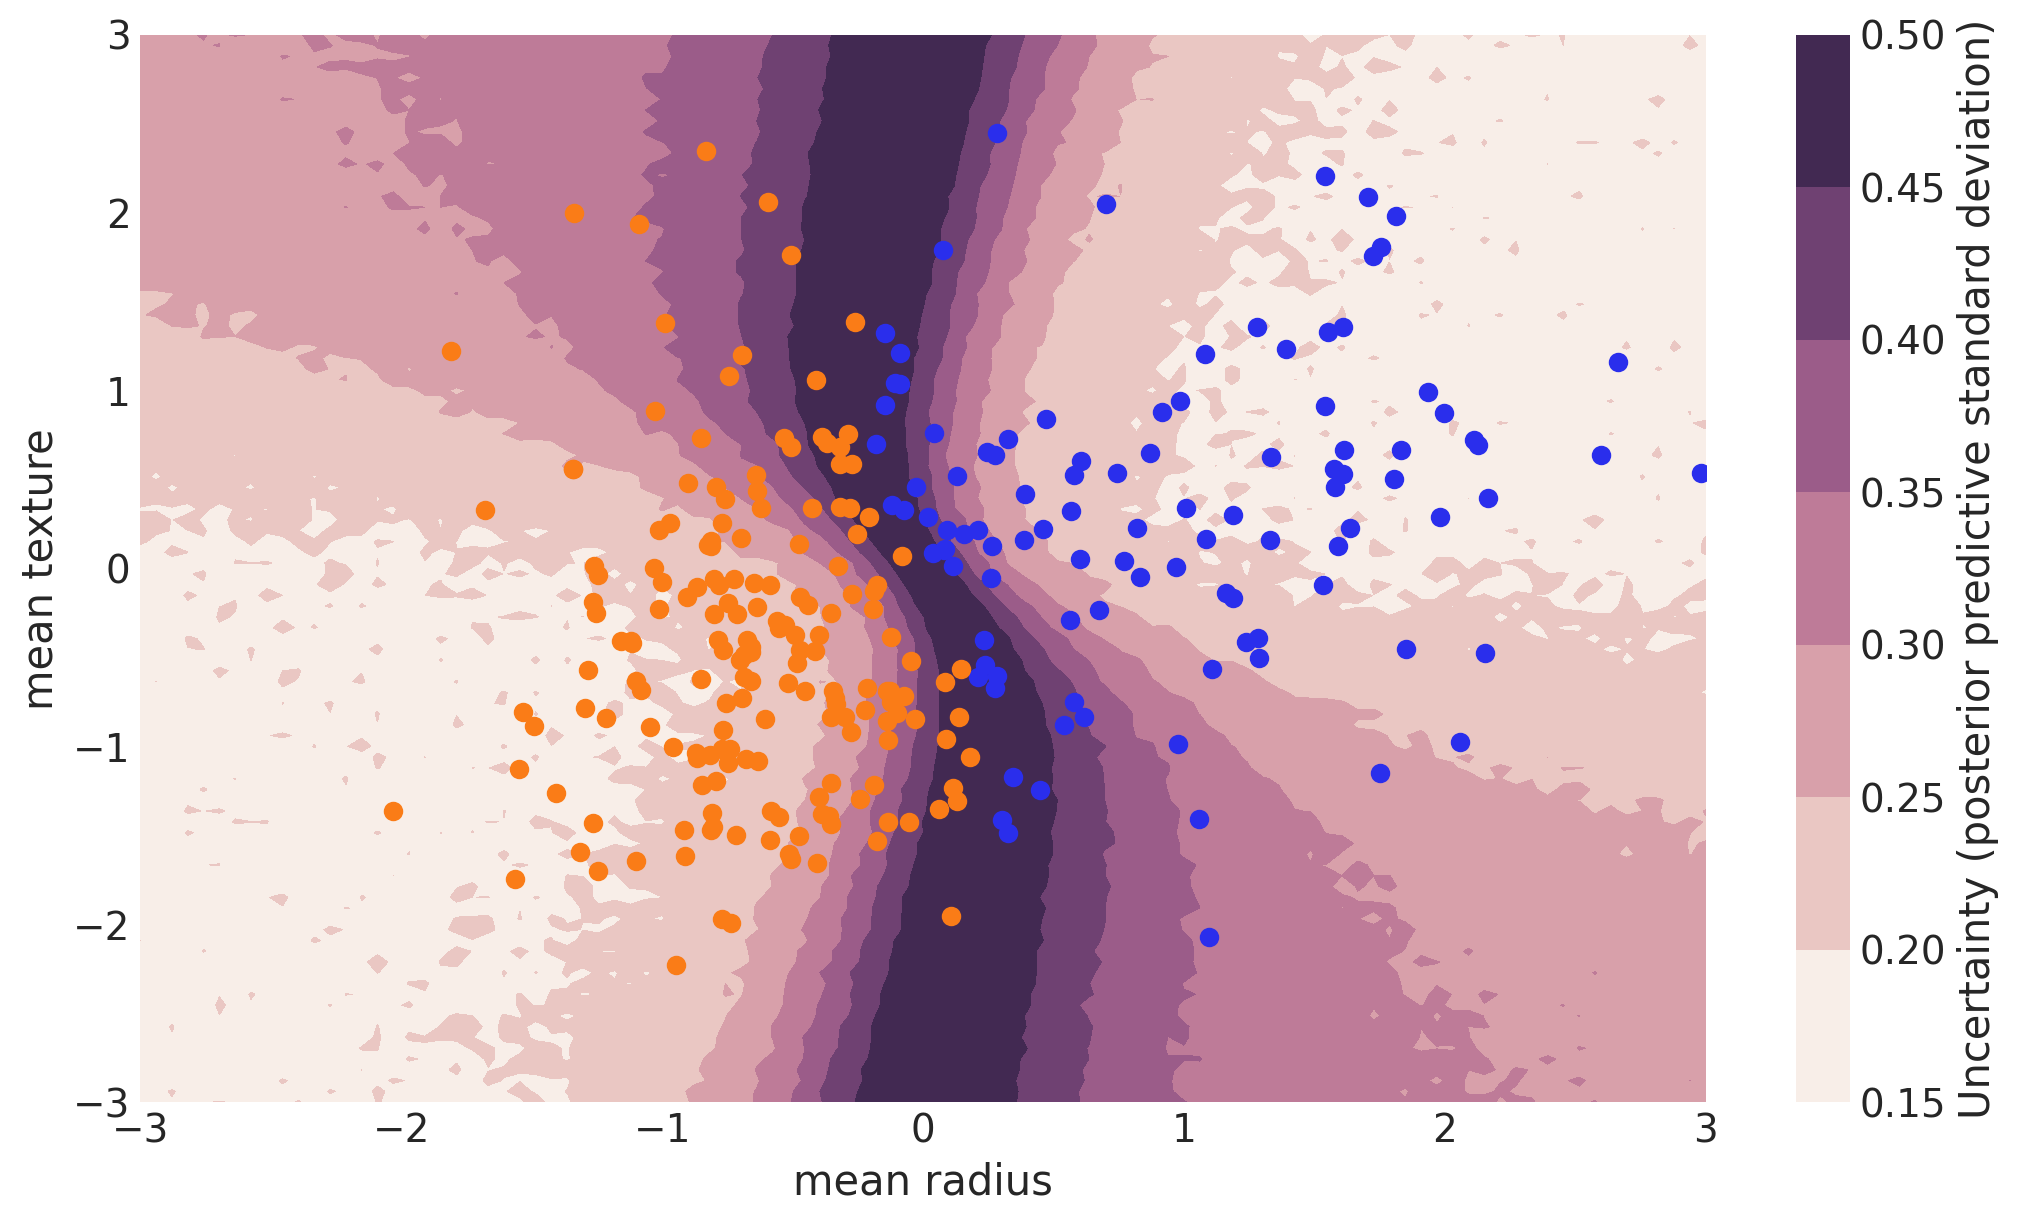

In [53]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(
    grid[0], grid[1], y_pred.squeeze().values.std(axis=0).reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="mean radius", ylabel="mean texture")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)");

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

### Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won’t scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:



In [54]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)

with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

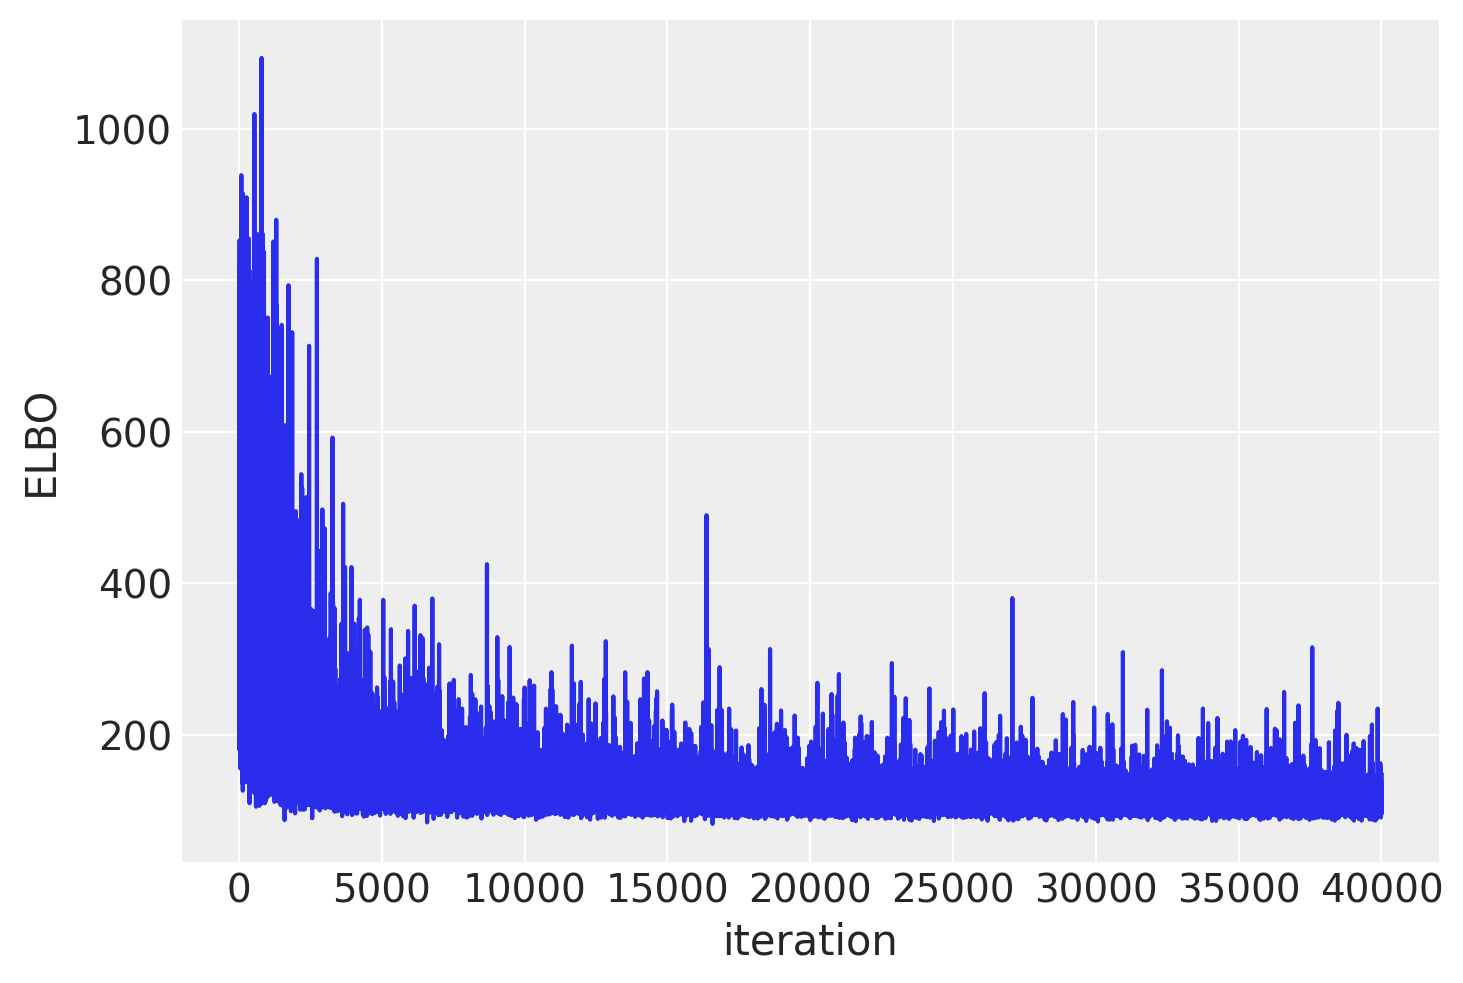

In [55]:
plt.plot(approx.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration");

In general, mini-batch ADVI’s running time is lower. It also typically converges faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


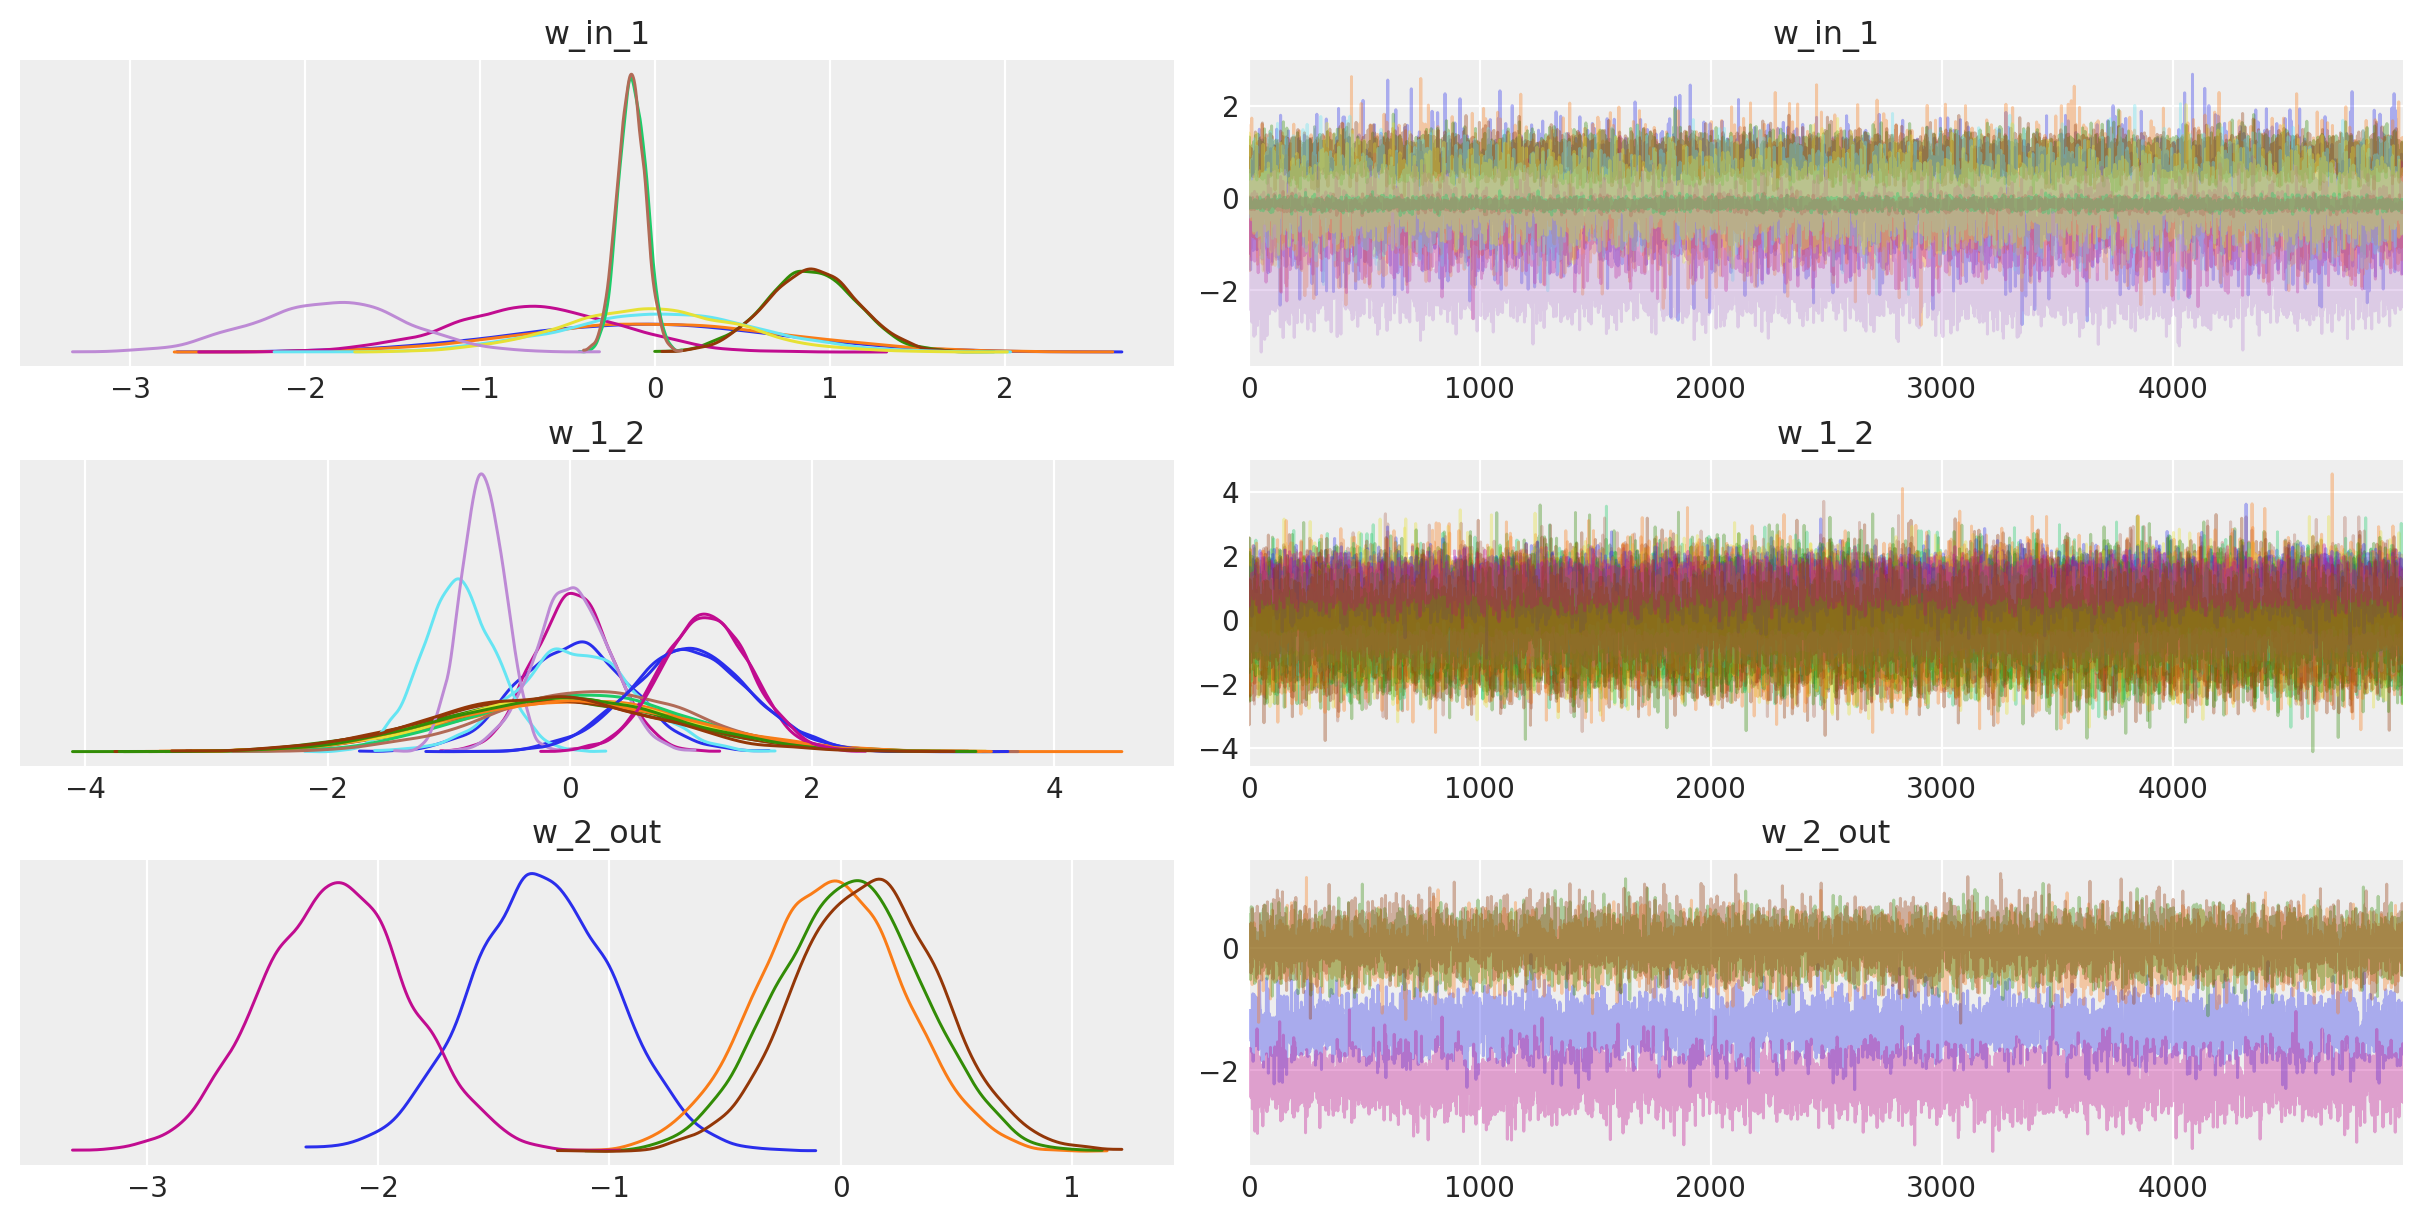

In [56]:
az.plot_trace(trace);

In [57]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc_mb = pm.sample_posterior_predictive(trace)
    trace.extend(ppc_mb)

In [58]:
pred_mb = ppc_mb.posterior_predictive["out"].mean(("chain", "draw")) > 0.5

In [59]:
print(f"Accuracy = {(Y_test == pred_mb.values).mean() * 100:.2f}%")

Accuracy = 87.37%
